<a href="https://colab.research.google.com/github/shreeya1810/gan/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Import and visualise the data

In [2]:
# we only want the training dataset to train the gan
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6L37CH_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6L37CH_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [4]:
# set up connection to the data pipeline (i.e. iterator)
data_iterator = ds.as_numpy_iterator()

In [5]:
# get the data from the pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

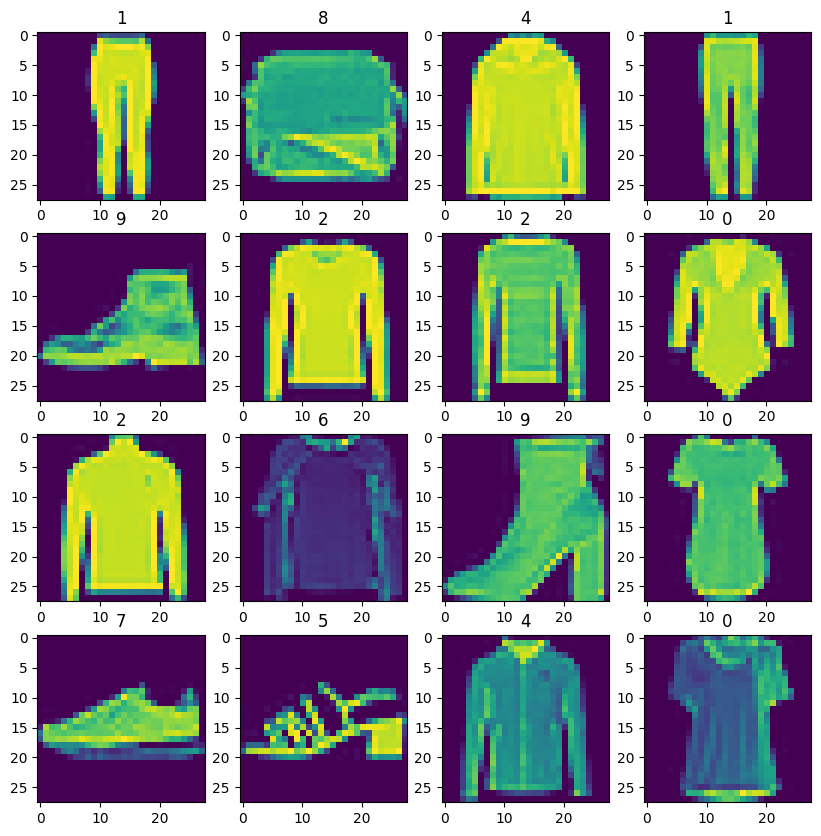

In [6]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for row in range(4):
  for col in range(4):
    batch = data_iterator.next()
    ax[row, col].imshow(batch['image'])
    ax[row, col].set_title(batch['label'])

In [7]:
def scale_images(data):
  image = data['image']
  return image/255

In [8]:
ds = tfds.load('fashion_mnist', split='train')
# map the scale_image() function to each image in the pipeline
ds = ds.map(scale_images)
# cache the dataset for that batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# create samples with 128 images each
ds = ds.batch(128)
# reduces likelihood of botle-necking
ds = ds.prefetch(64)

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

Build the Neural Network

In [10]:
# import the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# import the layers for the neural network
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, LeakyReLU, UpSampling2D, Reshape

In [11]:
def build_generator():
  model = Sequential()

  # take in a random vecror with 128 values reshape it to a 7*7*128 image
  # beginnings of a generated image

  model.add(Dense(7*7*128, input_dim=(128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))

  # up-sampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=(5, 5), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # up-sampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, kernel_size=(5, 5), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # add more convolutional layers
  model.add(Conv2D(1, kernel_size=(4, 4), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # some more..
  model.add(Conv2D(1, kernel_size=(4, 4), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  # conv layer to get one channel, and sigmoid to ensure that pixel values are between 0 and 1
  model.add(Conv2D(1, kernel_size=(4, 4), padding='same', activation='sigmoid'))

  return model

In [12]:
generator = build_generator()

In [13]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


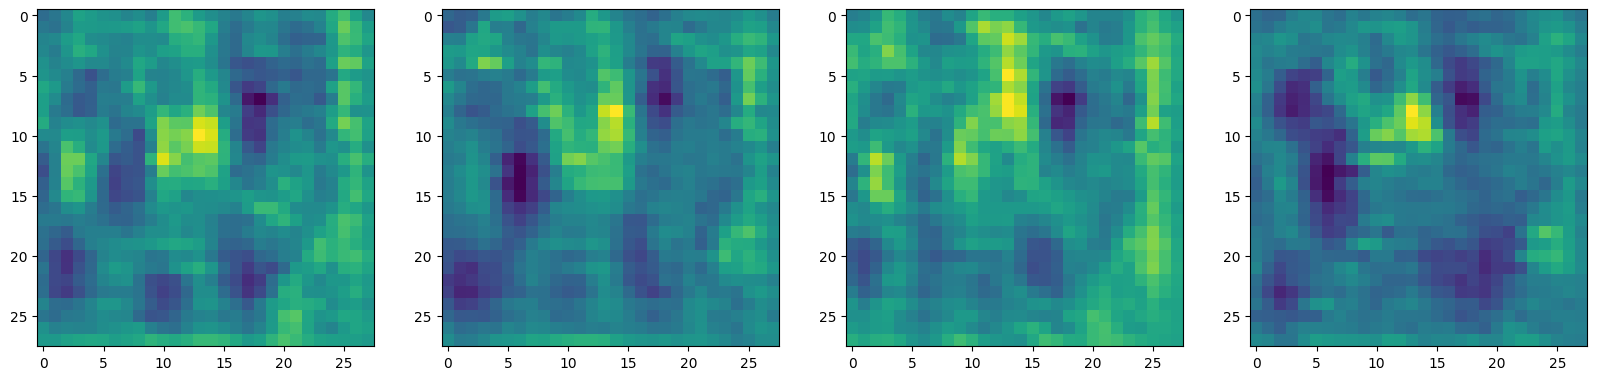

In [14]:
# generate four random images by passing four vectors of 128*1
img = generator.predict(np.random.rand(4, 128))
# display the images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4):
    ax[i].imshow(np.squeeze(img[i]))

In [15]:
def build_discriminator():
  model = Sequential()

  # first conv2d block
  model.add(Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  # second conv2d block
  model.add(Conv2D(64, kernel_size=(5, 5)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  # third conv2d block
  model.add(Conv2D(128, kernel_size=(5, 5)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  # fourth conv2d block
  model.add(Conv2D(256, kernel_size=(5, 5)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))

  # flatten then pass to dense layer
  model.add(Flatten())
  # model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [18]:
discriminator(img)

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.49557027],
       [0.49555656],
       [0.49558648],
       [0.4955589 ]], dtype=float32)>

Construct Training Loop

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [20]:
# learning rate for discriminator is lesser than that of generator
g_opt = Adam(learning_rate=0.0002)
d_opt = Adam(learning_rate=0.00002)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [21]:
from tensorflow.keras.models import Model

In [22]:
# create custom model

class FashionGAN(Model):
  def __init__(self, generator, discriminator):
    super(FashionGAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss):
    super(FashionGAN, self).compile()
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    # get the images
    real_images = batch
    fake_images = self.generator(np.random.rand(128, 128), training=False)

    # train the discriminator
    with tf.GradientTape() as d_tape:
      # pass the real and fake images in the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
      # create labels
      y_real = tf.ones_like(yhat_real)
      y_fake = tf.zeros_like(yhat_fake)
      y_realfake = tf.concat([y_real, y_fake], axis=0)
      # add some noise
      noise_real = 0.15 * tf.random.normal(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.normal(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)
      # calculate the loss
      d_loss_value = self.d_loss(y_realfake, yhat_realfake)

    # apply backpropogation
    d_gradients = d_tape.gradient(d_loss_value, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # train the generator
    with tf.GradientTape() as g_tape:
      # generate some new images
      fake_images = self.generator(np.random.rand(128, 128), training=True)
      # create predicted labels
      predicted_labels = self.discriminator(fake_images, training=False)
      # calculate the loss
      g_loss_value = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # apply backpropogation
    g_gradients = g_tape.gradient(g_loss_value, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {'d_loss': d_loss_value, 'g_loss': g_loss_value}


In [23]:
# create instance of model
fashgan = FashionGAN(generator, discriminator)

In [24]:
# compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [30]:
import os
from keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent = np.random.rand(self.num_img, self.latent_dim)
    generated_images = self.model.generator.predict(random_latent)
    generated_images *= 255
    # generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('generated_images', f'generated_image_{epoch}_{i}.png'))

In [34]:
# train the model
hist = fashgan.fit(ds, epochs=20)

Epoch 1/20
469/469 [==============================] - 50s 107ms/step - d_loss: -0.0029 - g_loss: 1.5251e-05
Epoch 2/20
469/469 [==============================] - 50s 107ms/step - d_loss: 0.0196 - g_loss: 7.6342e-05
Epoch 3/20
469/469 [==============================] - 51s 108ms/step - d_loss: 0.0067 - g_loss: 2.7143e-04
Epoch 4/20
469/469 [==============================] - 51s 108ms/step - d_loss: -0.0015 - g_loss: 3.7832e-04
Epoch 5/20
469/469 [==============================] - 51s 108ms/step - d_loss: -0.0016 - g_loss: 7.7992e-04
Epoch 6/20
469/469 [==============================] - 50s 107ms/step - d_loss: 1.9207e-04 - g_loss: 4.1047e-04
Epoch 7/20
469/469 [==============================] - 50s 107ms/step - d_loss: 0.0027 - g_loss: 1.4969e-04
Epoch 8/20
469/469 [==============================] - 50s 107ms/step - d_loss: -0.0027 - g_loss: 6.4166e-05
Epoch 9/20
469/469 [==============================] - 50s 106ms/step - d_loss: -0.0043 - g_loss: 4.8523e-04
Epoch 10/20
469/469 [=======

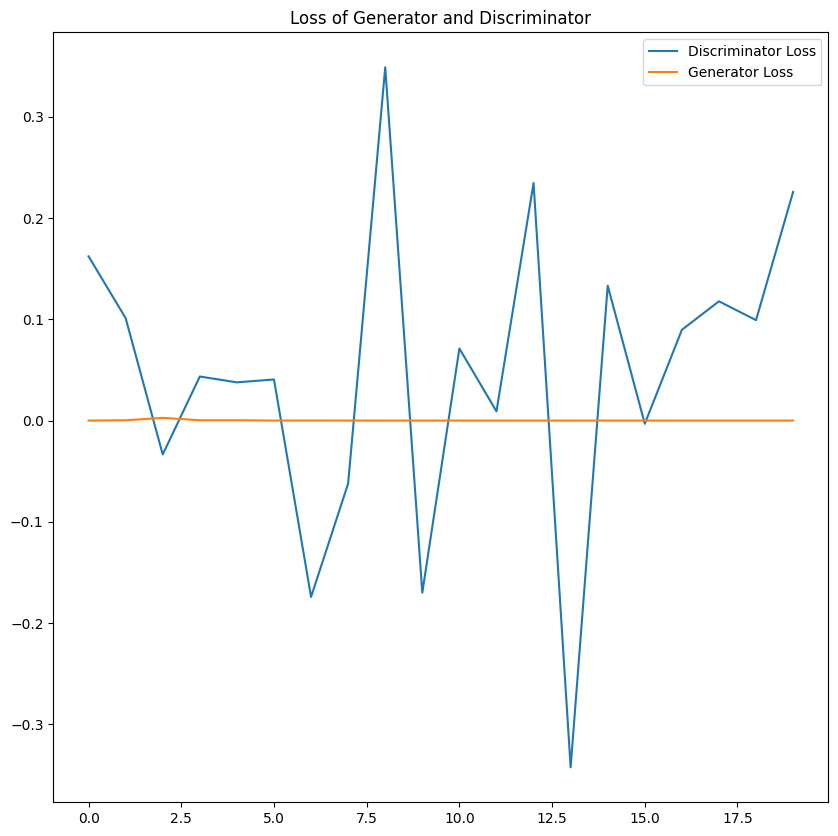

In [37]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

# plot the loss
ax1.plot(hist.history['d_loss'], label='Discriminator Loss')
ax1.plot(hist.history['g_loss'], label='Generator Loss')

# set title and legend
ax1.set_title('Loss of Generator and Discriminator')
ax1.legend()

# show the plot
plt.show()


In [35]:
generator.predict(np.random.rand(4, 128))

1/1 [==============================] - 0s 30ms/step


array([[[[9.9973685e-01],
         [9.9970227e-01],
         [9.9983633e-01],
         ...,
         [1.4060424e-03],
         [2.1510249e-02],
         [3.8626954e-01]],

        [[9.9995422e-01],
         [9.9999237e-01],
         [9.9999869e-01],
         ...,
         [2.2243753e-06],
         [2.2262023e-04],
         [4.3190200e-02]],

        [[9.9999368e-01],
         [9.9999964e-01],
         [1.0000000e+00],
         ...,
         [3.6843421e-08],
         [3.0547671e-05],
         [2.4452414e-02]],

        ...,

        [[6.9572388e-06],
         [4.9230632e-08],
         [6.0899148e-09],
         ...,
         [3.9632723e-02],
         [6.9654293e-02],
         [2.1295831e-01]],

        [[1.1691366e-03],
         [4.9467013e-05],
         [1.8942934e-05],
         ...,
         [1.5320565e-01],
         [1.9412491e-01],
         [2.9377788e-01]],

        [[4.0184446e-02],
         [8.6645398e-04],
         [6.7916227e-04],
         ...,
         [1.5348208e-01],
        

1/1 [==============================] - 0s 34ms/step


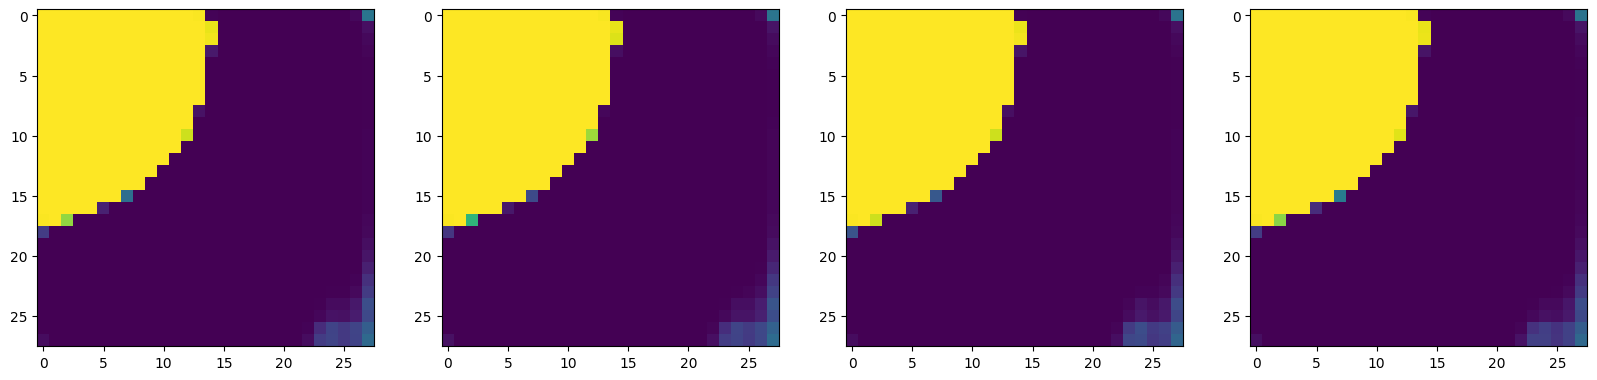

In [36]:
# generate four random images by passing four vectors of 128*1
img = generator.predict(np.random.rand(4, 128))
# display the images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4):
    ax[i].imshow(np.squeeze(img[i]))